<h2 style="color:red" align="center">Weight of Evidence and Information Value</h2>

### Weight of Evidence

WoE measures how strongly a category separates good loans from bad loans. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers.

$$
\text{WOE}
=
\ln\!\left(
\frac{\%\,  \text{of Good Customers}}
{\%\, \text{of Bad Customers}}
\right)
$$


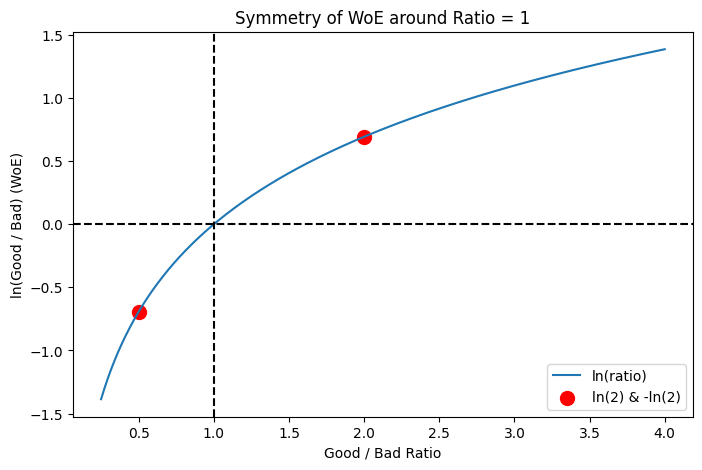

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Define log function (WoE style)
def logit(p):
    return np.log(p)

# Symmetric ratios around 1
ratios = np.linspace(0.25, 4, 500)  # covers <1 and >1

# Compute logs
log_ratios = logit(ratios)

# Plot
plt.figure(figsize=(8,5))
plt.plot(ratios, log_ratios, label="ln(ratio)")

# Highlight ln(2) and -ln(2)
plt.scatter([2, 0.5], [np.log(2), -np.log(2)], color='red', s=100, label="ln(2) & -ln(2)")

# Vertical and horizontal reference lines
plt.axhline(0, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')

# Labels, title, legend
plt.xlabel("Good / Bad Ratio")
plt.ylabel("ln(Good / Bad) (WoE)")
plt.title("Symmetry of WoE around Ratio = 1")
plt.legend()
plt.show()


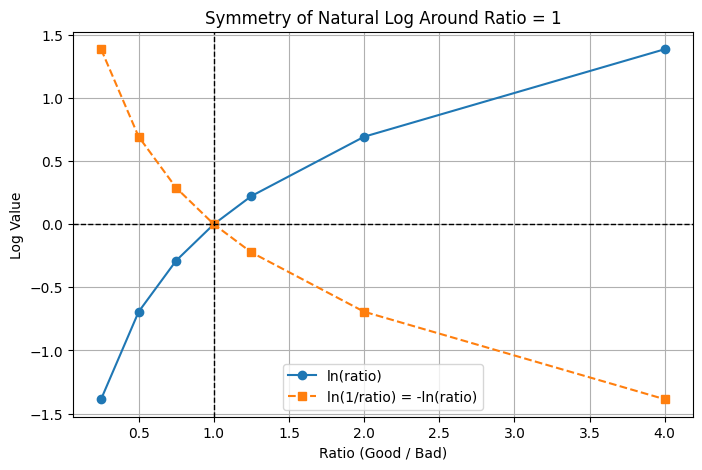

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Create ratios symmetric around 1
ratios = np.array([0.25, 0.5, 0.75, 1, 1.25, 2, 4])

# Compute ln(ratio) and ln(1/ratio)
ln_ratios = np.log(ratios)
ln_reciprocal = np.log(1 / ratios)

# Plot
plt.figure(figsize=(8,5))
plt.plot(ratios, ln_ratios, 'o-', label='ln(ratio)')
plt.plot(ratios, ln_reciprocal, 's--', label='ln(1/ratio) = -ln(ratio)')

# Reference lines
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(1, color='black', linestyle='--', linewidth=1)

# Labels and legend
plt.xlabel("Ratio (Good / Bad)")
plt.ylabel("Log Value")
plt.title("Symmetry of Natural Log Around Ratio = 1")
plt.legend()
plt.grid(True)
plt.show()


The ratio from WoE, tells direction of risk, but the log transforms it into a symmetric, additive scale that aligns with log-odds in logistic regression, which is why WoE uses the natural logarithm. In fact any monotonic transform function could work here, but regulators expect ln in based WoE.

In [43]:
mydata =pd.read_csv("binary.csv")

In [44]:
mydata.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


### Information value

Is used to measure predictive power of independent variables. It is used as a variable selection technique when dependen variable is binary.

| Information Value (IV) | Variable Predictiveness        |
|-----------------------:|--------------------------------|
| < 0.02                 | Not useful for prediction      |
| 0.02 – 0.10            | Weak predictive power          |
| 0.10 – 0.30            | Medium predictive power        |
| 0.30 – 0.50            | Strong predictive power        |
| > 0.50                 | Suspicious predictive power    |


In [ ]:
cols = mydata.columns
print(cols)
cols[~cols.isin(["admit"])]
mydata["admit"].dtype.kind in "bifc" and (len(np.unique(data[ivars]))>10):

Index(['admit', 'gre', 'gpa', 'rank'], dtype='str')


True

In [73]:
def iv_woe(data, target, bins =10, show_woe = False):

    ## Empty DataFrame
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Columns Names
    cols = data.columns

    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in "bifc") and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars],bins,duplicates="drop")
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x",as_index =False).agg({"y":["count","sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF
    


iv_woe(data = mydata, target = 'admit', bins=10, show_woe = False)

Information value of gre is 0.312882
Information value of gpa is 0.27002
Information value of rank is 0.292044


(  Variable        IV
 0      gre  0.312882
 0      gpa  0.270020
 0     rank  0.292044,
   Variable            Cutoff    N  Events  Non-Events  % of Events  \
 0      gre  (219.999, 440.0]   48       6          42     0.047244   
 1      gre    (440.0, 500.0]   51      12          39     0.094488   
 2      gre    (500.0, 520.0]   24      10          14     0.078740   
 3      gre    (520.0, 560.0]   51      15          36     0.118110   
 4      gre    (560.0, 580.0]   29       6          23     0.047244   
 5      gre    (580.0, 620.0]   53      21          32     0.165354   
 6      gre    (620.0, 660.0]   45      17          28     0.133858   
 7      gre    (660.0, 680.0]   20       9          11     0.070866   
 8      gre    (680.0, 740.0]   44      12          32     0.094488   
 9      gre    (740.0, 800.0]   35      19          16     0.149606   
 0      gpa      (2.259, 2.9]   43       8          35     0.062992   
 1      gpa      (2.9, 3.048]   37      11          26     